<a href="https://colab.research.google.com/github/Arawat99/notebook/blob/main/Keras_AG_News_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AG News Sentimental Classification Task in Keras

Fine tuning distilbert-base-uncased model to classify news text into four classes: World, Sports, Business, and Sci/Tech.

In [1]:
# To make the dataset load in google colab without error
!pip install -U datasets

# To install compatible version between the two libraries
!pip install --upgrade transformers
!pip install --upgrade tf_keras

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
# # To restart runtime and use the installed libraries
# import os
# os.kill(os.getpid(), 9)

### Importing Libraries

In [32]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from wandb.integration.keras import WandbCallback
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import wandb
import os

In [6]:
wandb.login()
wandb.init(
    project="Keras AG New Classifier",
    name="experiment-1",
    config={
        "epochs": 2,
        "batch_size": 32,
        "optimizer": "adam",
        "learning_rate": 1e-5,
    }
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chris-joshua-olaguera (chris-joshua-olaguera-centro-escolar-university-official) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
# Speed up training
tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy("mixed_float16")

### Load Dataset

In [8]:
ds = load_dataset("fancyzhx/ag_news")
ds

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [9]:
df = pd.DataFrame(ds["train"])
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [10]:
df["label"].unique()

array([2, 3, 1, 0])

In [11]:
labels = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

In [12]:
print(f"Text: { df['text'][0] }")
print(f"Label: { labels[df['label'][0]] }")

Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label: Business


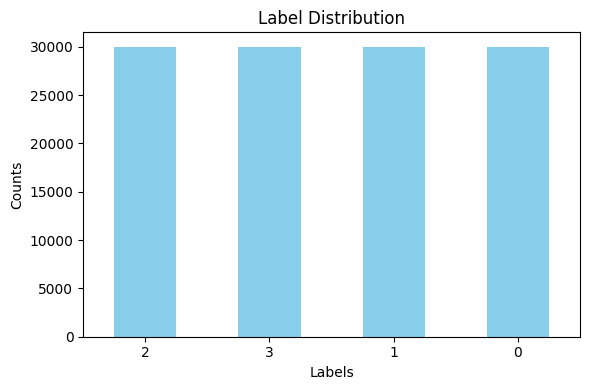

In [13]:
label_counts = df["label"].value_counts()

plt.figure(figsize=(6, 4))
label_counts.plot(kind="bar", color="skyblue")

plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Spliting the train dataset into train and test, and test to eval

In [14]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

In [15]:
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

final_ds = DatasetDict({
    "train": train_ds.remove_columns("__index_level_0__"),
    "test": test_ds.remove_columns("__index_level_0__"),
    "eval": ds["test"]
})

final_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 96000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 24000
    })
    eval: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Loading Model and Tokenizer

In [16]:
model_name = "distilbert-base-uncased"

In [17]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
model.summary()

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were n

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66956548 (255.42 MB)
Trainable params: 66956548 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

### Preprocessing

In [19]:
def preprocessing(data):
    return tokenizer(data["text"], truncation=True, padding="longest")

tokenized_ds = ds.map(preprocessing, batched=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = model.prepare_tf_dataset(
    tokenized_ds["train"], batch_size=32, shuffle=True, tokenizer=tokenizer
).cache().prefetch(buffer_size=AUTOTUNE)

test_ds = model.prepare_tf_dataset(
    tokenized_ds["test"], batch_size=64, shuffle=False, tokenizer=tokenizer
).cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

### Load Model Checkpoint

### Training Model

In [23]:
history = model.fit(train_ds, validation_data=test_ds, epochs=2, callbacks=[WandbCallback(save_model=True)])

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/2
3750/3750 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9208

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20250707_072902-0lsl571x/files/model-best)... Done. 13.6s


3750/3750 [==============================] - 1659s 424ms/step - loss: 0.2419 - accuracy: 0.9208 - val_loss: 0.1776 - val_accuracy: 0.9393
Epoch 2/2
3750/3750 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9499

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20250707_072902-0lsl571x/files/model-best)... Done. 37.2s


3750/3750 [==============================] - 1321s 352ms/step - loss: 0.1483 - accuracy: 0.9499 - val_loss: 0.1696 - val_accuracy: 0.9434


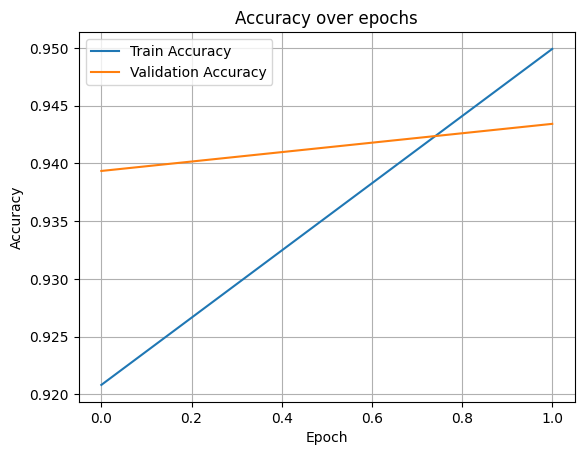

In [24]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

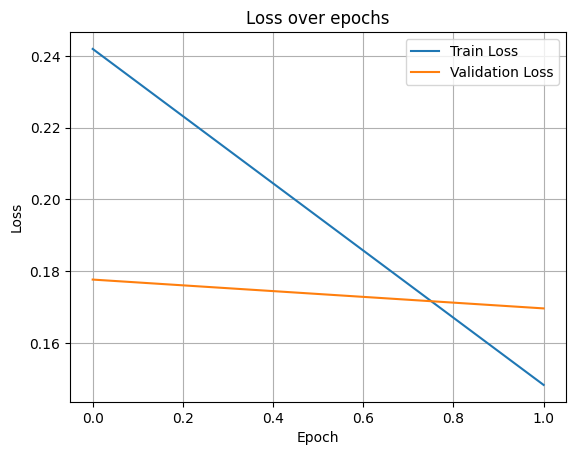

In [25]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluating Model

In [26]:
tokenized_test_ds = final_ds["eval"].map(preprocessing, batched=True)
tokenized_test_ds

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 7600
})

In [57]:
eval_ds = model.prepare_tf_dataset(
    tokenized_test_ds, batch_size=64, shuffle=False, tokenizer=tokenizer
).cache().prefetch(buffer_size=AUTOTUNE)

In [58]:
logits = model.predict(eval_ds)

if isinstance(logits, tuple):
    logits = logits[0]
elif isinstance(logits, dict) and 'logits' in logits:
    logits = logits['logits']

logits = np.array(logits)
predicted_classes = np.argmax(logits, axis=1)

119/119 [==============================] - 15s 121ms/step


In [59]:
predicted_classes

array([2, 3, 3, ..., 1, 2, 2])

In [64]:
accuracy = accuracy_score(final_ds["eval"]["label"], predicted_classes)

print(f"Total Accuracy Percentage: {accuracy * 100:.2f}%\n")
print(classification_report(final_ds["eval"]["label"], predicted_classes))

Total Accuracy Percentage: 94.34%

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1900
           1       0.99      0.99      0.99      1900
           2       0.91      0.92      0.92      1900
           3       0.92      0.92      0.92      1900

    accuracy                           0.94      7600
   macro avg       0.94      0.94      0.94      7600
weighted avg       0.94      0.94      0.94      7600



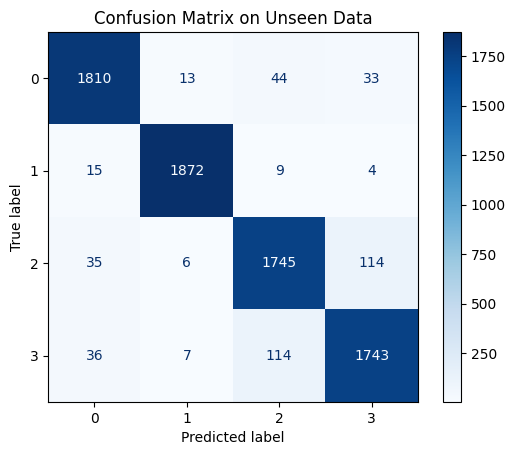

In [61]:
cm = confusion_matrix(final_ds["eval"]["label"], predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Unseen Data")
plt.show()

In [63]:
for i, (text, true, pred) in enumerate(zip(final_ds["eval"]["text"], final_ds["eval"]["label"], predicted_classes)):
    if i >= 100:
        break
    print(f"Text: { text }\nTrue Label: { labels[true] } | Predicted: { labels[int(pred)] }\n")


Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
True Label: 2 | Predicted: 2

Text: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
True Label: 2 | Predicted: 2

Text: Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.
True Label: 2 | Predicted: 2

Text: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figu